In [1]:
# Step 1: Load Dataset
import pandas as pd

# Load the CSV file
df = pd.read_csv("creditcard.csv")

# Display basic info
print("Dataset Loaded Successfully!")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum().sum())
print("\nClass Distribution:\n", df['Class'].value_counts())
print("\nData Preview:\n", df.head())


Dataset Loaded Successfully!
Shape: (284807, 31)

Columns:
 ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing Values:
 0

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Data Preview:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.2778

In [2]:
# Step 2: Train-Test Split and Standard Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train-Test Split Done!")
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

# Initialize scaler
scaler = StandardScaler()

# Fit only on training data to prevent data leakage
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

print("Standard Scaling applied on 'Time' and 'Amount' (fit on train, transform on test)")
print(X_train[['Time', 'Amount']].head())


Train-Test Split Done!
Training Shape: (227845, 30)
Testing Shape: (56962, 30)
Standard Scaling applied on 'Time' and 'Amount' (fit on train, transform on test)
            Time    Amount
265518  1.411588 -0.322494
180305  0.623141 -0.339764
42664  -1.130680  0.346693
198723  0.794699 -0.327360
82325  -0.748102 -0.008281


In [3]:
# Step 3: Apply SMOTE on Training Data Only
from imblearn.over_sampling import SMOTE

# Initialize SMOTE (you can tune sampling_strategy if needed)
smote = SMOTE(random_state=42)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("SMOTE Applied Successfully!")
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", y_train_resampled.value_counts().to_dict())
print("Resampled Training Shape:", X_train_resampled.shape)


SMOTE Applied Successfully!
Before SMOTE: {0: 227451, 1: 394}
After SMOTE : {0: 227451, 1: 227451}
Resampled Training Shape: (454902, 30)


/var/folders/m0/62cx_w0d7bz_hj8s72yjln6h0000gn/T/ipykernel_33335/3987077558.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


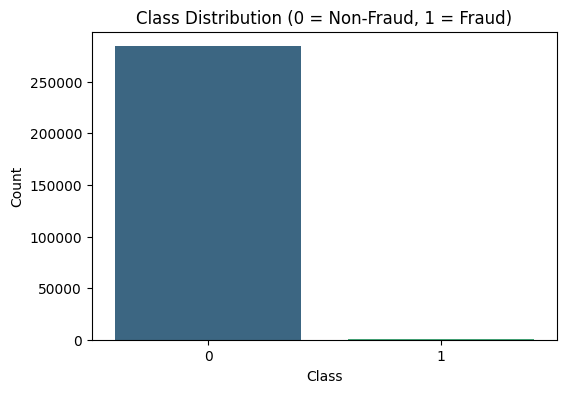

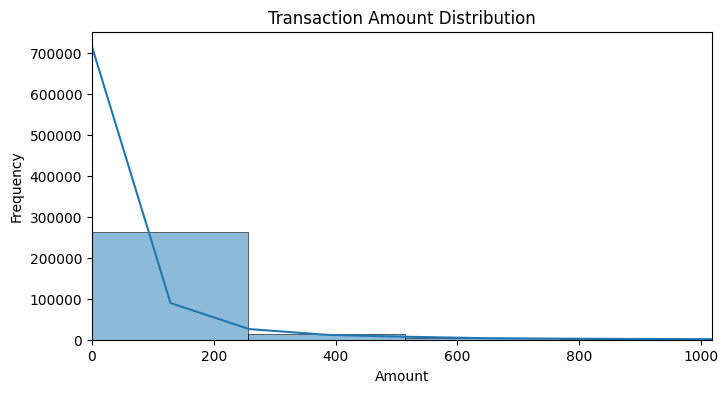

In [4]:
# Step 4: Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution -----
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#Amount Distribution -----
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, df['Amount'].quantile(0.99))  # remove extreme outliers for clarity
plt.show()




Decision Tree Model Trained Successfully!

Accuracy: 0.9970331097924933

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9974    0.9985     56864
           1     0.3408    0.7755    0.4735        98

    accuracy                         0.9970     56962
   macro avg     0.6702    0.8865    0.7360     56962
weighted avg     0.9985    0.9970    0.9976     56962



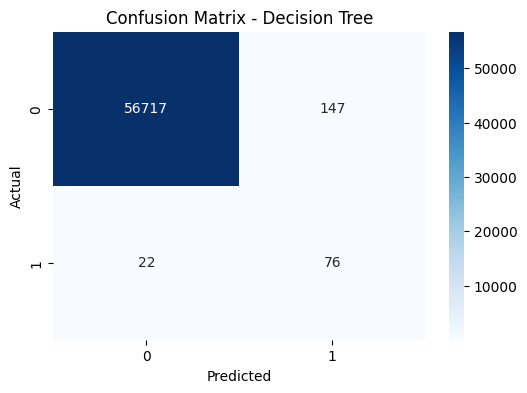

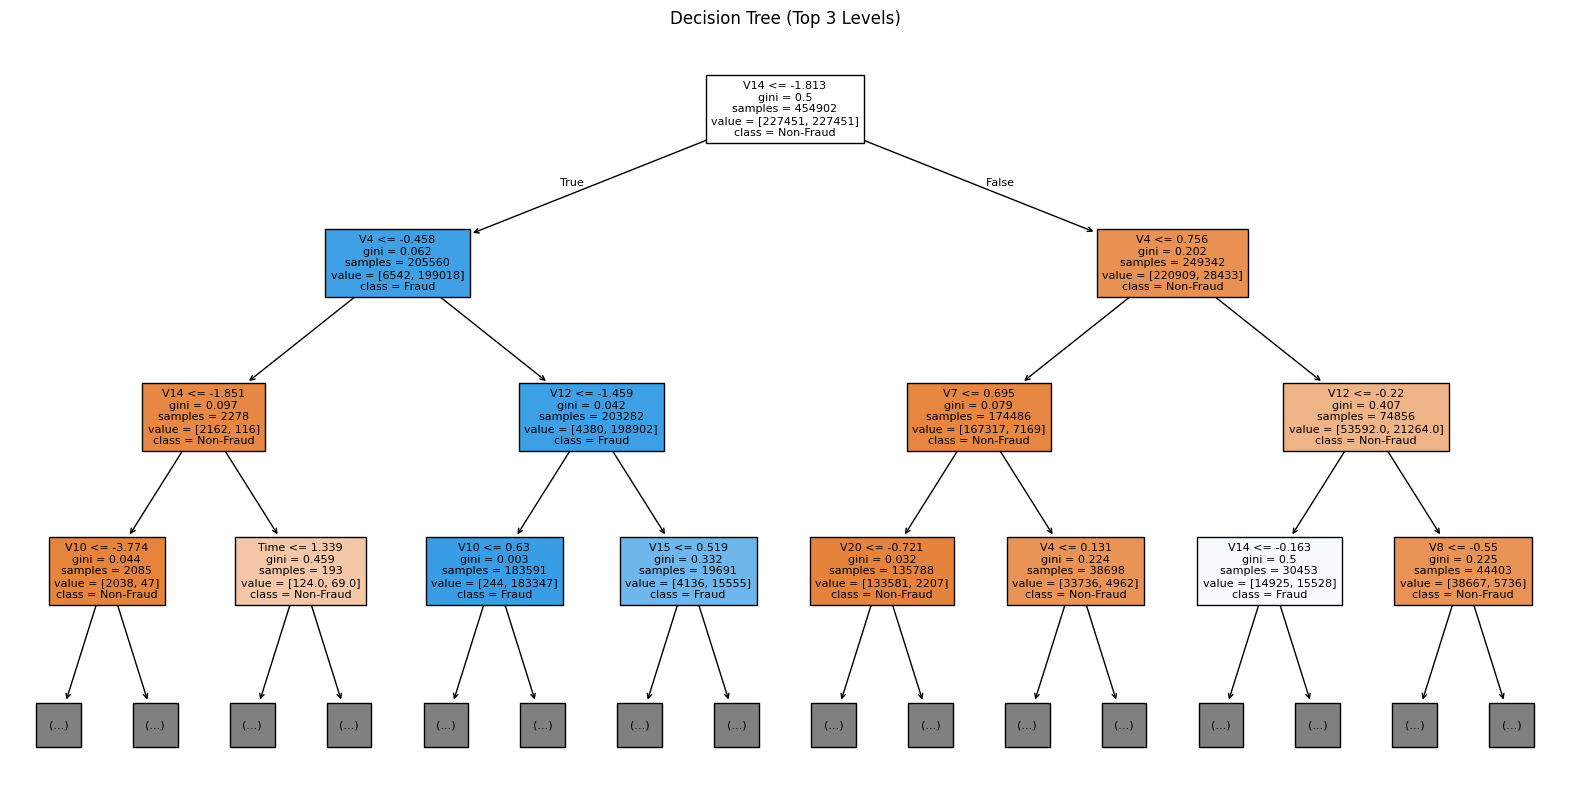

In [5]:
# Step 5: Train Decision Tree Model
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
dt = DecisionTreeClassifier(
    criterion='gini',       # or 'entropy'
    max_depth=None,         # can tune later
    random_state=42
)

# Fit on SMOTE-resampled training data
dt.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = dt.predict(X_test)

# ---------- Evaluation ----------
print("Decision Tree Model Trained Successfully!\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------- (Optional) Visualize the Tree ----------
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    filled=True,
    feature_names=X_train.columns,
    class_names=['Non-Fraud','Fraud'],
    max_depth=3,            # visualize only top levels
    fontsize=8
)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()


In [6]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [7]:
# Step 7: Hyperparameter Optimization using Optuna
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create model with sampled hyperparameters
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Fit on SMOTE-resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on validation (test) data
    y_pred_val = model.predict(X_test)
    
    # Calculate F1-score (good for imbalance)
    score = f1_score(y_test, y_pred_val)
    
    return score

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Display the best hyperparameters
print("Best Trial:")
print(study.best_trial.params)

# Train the final Decision Tree with best parameters
best_params = study.best_trial.params
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train_resampled, y_train_resampled)

# Predictions on test set
y_pred_optuna = best_dt.predict(X_test)

# ---------- Evaluation ----------
print("\nDecision Tree (Optuna Tuned) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_optuna))
print("\nClassification Report:\n", classification_report(y_test, y_pred_optuna, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optuna)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd')
plt.title("Confusion Matrix - Optuna Tuned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------- Plot Optuna optimization history ----------
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.show()

# ---------- Plot parameter importance ----------
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Optuna Hyperparameter Importance")
plt.show()


/Users/kailashsou/Desktop/Credit Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-18 15:44:32,843] A new study created in memory with name: no-name-fa404311-b0d9-4da2-a36f-d072fb996dba
Best trial: 0. Best value: 0.300181:   2%|▏         | 1/50 [00:13<11:04, 13.55s/it]

[I 2025-11-18 15:44:46,402] Trial 0 finished with value: 0.30018083182640143 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.30018083182640143.


Best trial: 0. Best value: 0.300181:   4%|▍         | 2/50 [00:25<10:15, 12.82s/it]

[I 2025-11-18 15:44:58,713] Trial 1 finished with value: 0.1228878648233487 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.30018083182640143.


Best trial: 0. Best value: 0.300181:   6%|▌         | 3/50 [00:41<11:06, 14.18s/it]

[I 2025-11-18 15:45:14,515] Trial 2 finished with value: 0.2 and parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.30018083182640143.


Best trial: 0. Best value: 0.300181:   8%|▊         | 4/50 [00:59<12:02, 15.71s/it]

[I 2025-11-18 15:45:32,556] Trial 3 finished with value: 0.26158940397350994 and parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.30018083182640143.


Best trial: 4. Best value: 0.306202:  10%|█         | 5/50 [01:19<12:53, 17.20s/it]

[I 2025-11-18 15:45:52,397] Trial 4 finished with value: 0.3062015503875969 and parameters: {'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.3062015503875969.


Best trial: 4. Best value: 0.306202:  12%|█▏        | 6/50 [01:24<09:36, 13.10s/it]

[I 2025-11-18 15:45:57,554] Trial 5 finished with value: 0.042826552462526764 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.3062015503875969.


Best trial: 4. Best value: 0.306202:  14%|█▍        | 7/50 [01:35<08:56, 12.47s/it]

[I 2025-11-18 15:46:08,728] Trial 6 finished with value: 0.10361445783132531 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.3062015503875969.


Best trial: 4. Best value: 0.306202:  16%|█▌        | 8/50 [01:40<07:05, 10.12s/it]

[I 2025-11-18 15:46:13,819] Trial 7 finished with value: 0.042826552462526764 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.3062015503875969.


Best trial: 8. Best value: 0.497006:  18%|█▊        | 9/50 [01:55<07:47, 11.39s/it]

[I 2025-11-18 15:46:28,012] Trial 8 finished with value: 0.49700598802395207 and parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.49700598802395207.


Best trial: 8. Best value: 0.497006:  20%|██        | 10/50 [02:08<08:04, 12.10s/it]

[I 2025-11-18 15:46:41,694] Trial 9 finished with value: 0.36807095343680707 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.49700598802395207.


Best trial: 10. Best value: 0.5209:  22%|██▏       | 11/50 [02:23<08:17, 12.74s/it] 

[I 2025-11-18 15:46:55,899] Trial 10 finished with value: 0.5209003215434084 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.5209003215434084.


Best trial: 11. Best value: 0.532051:  24%|██▍       | 12/50 [02:37<08:24, 13.28s/it]

[I 2025-11-18 15:47:10,393] Trial 11 finished with value: 0.532051282051282 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  26%|██▌       | 13/50 [02:52<08:25, 13.67s/it]

[I 2025-11-18 15:47:24,967] Trial 12 finished with value: 0.5225806451612903 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  28%|██▊       | 14/50 [03:07<08:26, 14.06s/it]

[I 2025-11-18 15:47:39,917] Trial 13 finished with value: 0.5109034267912772 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  30%|███       | 15/50 [03:21<08:11, 14.03s/it]

[I 2025-11-18 15:47:53,886] Trial 14 finished with value: 0.18478260869565216 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  32%|███▏      | 16/50 [03:34<07:55, 13.97s/it]

[I 2025-11-18 15:48:07,732] Trial 15 finished with value: 0.3878504672897196 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  34%|███▍      | 17/50 [03:49<07:45, 14.10s/it]

[I 2025-11-18 15:48:22,118] Trial 16 finished with value: 0.5311475409836065 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  36%|███▌      | 18/50 [04:03<07:29, 14.06s/it]

[I 2025-11-18 15:48:36,089] Trial 17 finished with value: 0.18441273326015367 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  38%|███▊      | 19/50 [04:11<06:26, 12.47s/it]

[I 2025-11-18 15:48:44,845] Trial 18 finished with value: 0.0763765541740675 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  40%|████      | 20/50 [04:25<06:23, 12.79s/it]

[I 2025-11-18 15:48:58,386] Trial 19 finished with value: 0.2740619902120718 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 11 with value: 0.532051282051282.


Best trial: 11. Best value: 0.532051:  42%|████▏     | 21/50 [04:39<06:24, 13.27s/it]

[I 2025-11-18 15:49:12,775] Trial 20 finished with value: 0.44266666666666665 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.532051282051282.


Best trial: 21. Best value: 0.546667:  44%|████▍     | 22/50 [04:54<06:22, 13.65s/it]

[I 2025-11-18 15:49:27,301] Trial 21 finished with value: 0.5466666666666666 and parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.5466666666666666.


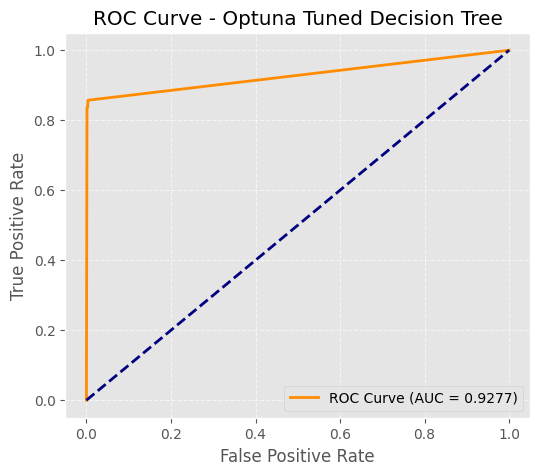

✅ ROC AUC Score: 0.9277


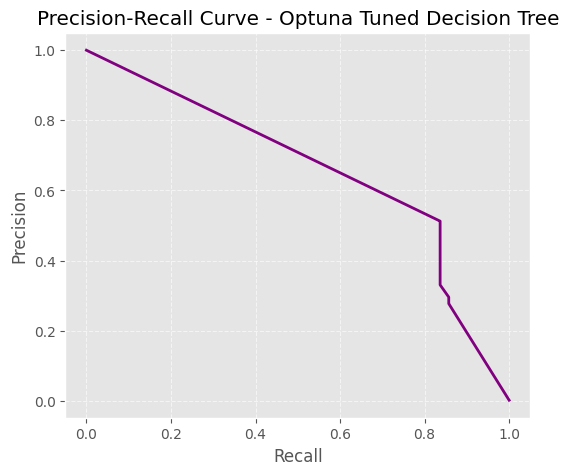

In [ ]:
# Step 8: ROC and AUC Curve
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

import matplotlib.pyplot as plt

# Get predicted probabilities for class = 1 (Fraud)
y_proba = best_dt.predict_proba(X_test)[:, 1]

# ---------- ROC Curve ----------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optuna Tuned Decision Tree')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# ---------- Precision-Recall Curve ----------
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Optuna Tuned Decision Tree')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score

# def objective(trial):
#     # Define the search space for hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 100, 400)
#     max_depth = trial.suggest_int('max_depth', 4, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
#     criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
#     # Build model with these parameters
#     model = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         criterion=criterion,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     # Fit and evaluate using F1 score
#     model.fit(X_train_resampled, y_train_resampled)
#     y_pred = model.predict(X_test)
#     f1 = f1_score(y_test, y_pred)
#     return f1

# # Create and run the Optuna study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30, show_progress_bar=True)

# # Print best trial
# print("✅ Best Trial:")
# print("F1 Score:", study.best_trial.value)
# print("Best Params:", study.best_trial.params)


[I 2025-11-13 23:48:13,995] A new study created in memory with name: no-name-cc86cea3-3d5b-4c4f-9a05-db217f9ccab3
Best trial: 0. Best value: 0.633588:   3%|▎         | 1/30 [02:30<1:12:41, 150.41s/it]

[I 2025-11-13 23:50:44,385] Trial 0 finished with value: 0.6335877862595419 and parameters: {'n_estimators': 373, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.6335877862595419.


Best trial: 0. Best value: 0.633588:   7%|▋         | 2/30 [03:35<46:39, 99.97s/it]   

[I 2025-11-13 23:51:49,058] Trial 1 finished with value: 0.39816933638443935 and parameters: {'n_estimators': 390, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.6335877862595419.


Best trial: 2. Best value: 0.781818:  10%|█         | 3/30 [04:44<38:39, 85.91s/it]

[I 2025-11-13 23:52:58,251] Trial 2 finished with value: 0.7818181818181819 and parameters: {'n_estimators': 184, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 2 with value: 0.7818181818181819.


Best trial: 2. Best value: 0.781818:  13%|█▎        | 4/30 [05:49<33:46, 77.94s/it]

[I 2025-11-13 23:54:03,975] Trial 3 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 179, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 2 with value: 0.7818181818181819.


Best trial: 2. Best value: 0.781818:  17%|█▋        | 5/30 [06:51<30:04, 72.18s/it]

[I 2025-11-13 23:55:05,935] Trial 4 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 142, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 2 with value: 0.7818181818181819.


In [ ]:
# Train final model with best hyperparameters
best_rf = RandomForestClassifier(
    **study.best_trial.params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_resampled, y_train_resampled)
y_pred_best = best_rf.predict(X_test)
y_pred_best_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nFinal Random Forest with Optuna-Tuned Hyperparameters\n")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, digits=4))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC–AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_best_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve - Tuned Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [ ]:
pip install xgboost optuna


In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objective(trial):
    # Define hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),  # helps class imbalance
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Train model
    model = XGBClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    return score

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Best parameters
print("Best Trial:")
print("F1 Score:", study.best_trial.value)
print("Best Params:", study.best_trial.params)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Train final model
best_xgb = XGBClassifier(
    **study.best_trial.params,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb = best_xgb.predict(X_test)
y_pred_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("\nFinal XGBoost Model with Optuna-Tuned Hyperparameters\n")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, digits=4))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC–AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve - Tuned XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [ ]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)


In [ ]:
pip install lightgbm optuna


In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

def objective(trial):
    # Define search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    # Build model
    model = LGBMClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict and compute F1-score
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    return score

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Print best trial
print("Best Trial:")
print("F1 Score:", study.best_trial.value)
print("Best Params:", study.best_trial.params)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Train final model
best_lgbm = LGBMClassifier(
    **study.best_trial.params,
    random_state=42,
    n_jobs=-1
)

best_lgbm.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_lgbm = best_lgbm.predict(X_test)
y_pred_lgbm_proba = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluation
print("\nFinal LightGBM Model with Optuna-Tuned Hyperparameters\n")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm, digits=4))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Tuned LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC–AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lgbm_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve - Tuned LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [ ]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)


In [ ]:
import pandas as pd

feature_importances = pd.Series(best_lgbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances[:15], y=feature_importances[:15].index, palette='mako')
plt.title("Top 15 Important Features - LightGBM")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()
